# Was importiert Deutschland aus den USA?

## Daten

- Außenhandelsstatistik, 2-Steller: https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0007
- Außenhandelsstatistik, 4-Steller: https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0009
- Außenhandelsstatistik, 8-Steller: https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0015
- Länderverzeichnis für die Außenhandelsstatistik: Genesis API (https://www-genesis.destatis.de/genesisWS/rest/2020/catalogue/values2variable)
- Warenverzeichnis für die Außenhandelsstatistik: Genesis API (https://www-genesis.destatis.de/genesisWS/rest/2020/catalogue/values2variable)

## Notizen

- Combined Nomenclature: https://taxation-customs.ec.europa.eu/customs-4/calculation-customs-duties/customs-tariff/combined-nomenclature_de
- a.n.g. = anderweitig nicht genannt


In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import sys
import json
from io import StringIO
from tqdm import tqdm
tqdm.pandas()
from dotenv import dotenv_values
secrets = dotenv_values(".env") 

sys.path.append('..')
from utils.get_destatis_variable_values import get_destatis_variable_values
from utils.get_destatis_table import get_destatis_table
from utils.try_cache import try_cache
from utils.plot_nested_treemap import plot_nested_treemap
from utils.plot_nested_treemap import sort_tree

In [18]:
raw = {}
data = {}

In [19]:
raw["impex2d"] = pd.read_csv("./data/51000-0007_de_flat.csv",
                               	delimiter=";",
                               	decimal=",",
                               	thousands=".",
                               	parse_dates=["time"],
                               	converters={ "value": lambda x: pd.to_numeric(x, errors="coerce")})

raw["impex8d"] =  pd.read_csv("./data/51000-0013_de_flat.csv",
								delimiter=";",
								decimal=",",
								thousands=".",
								parse_dates=["time"],
								converters={"value": lambda x: pd.to_numeric(x, errors="coerce")})

In [20]:
raw["country_codes"] = try_cache("./data/genesis-countries.json", lambda: get_destatis_variable_values(var="STLAH", token=secrets["DESTATIS_TOKEN"]))
data["country_codes"] = pd.DataFrame(data=json.loads(raw["country_codes"])["List"])

raw["product_codes_4d"] = try_cache("./data/genesis-products-4d.json", lambda: get_destatis_variable_values(var="WAM4", token=secrets["DESTATIS_TOKEN"]))
data["product_codes_4d"] = pd.DataFrame(data=json.loads(raw["product_codes_4d"])["List"])

raw["product_codes_6d"] = try_cache("./data/genesis-products-6d.json", lambda: get_destatis_variable_values(var="WAM6", token=secrets["DESTATIS_TOKEN"]))
data["product_codes_6d"] = pd.DataFrame(data=json.loads(raw["product_codes_6d"])["List"])

In [21]:
# Own research
data["food_codes_2d"] = ["WA01", "WA02", "WA03", "WA04", "WA07", "WA08", "WA09", "WA10", "WA11", "WA15", "WA16", "WA17", "WA18", "WA19", "WA20", "WA21", "WA22",]
data["food_codes_4d"] = data["product_codes_4d"].loc[data["product_codes_4d"]["Code"].str[:4].isin(data["food_codes_2d"])]["Code"]
data["food_codes_6d"] = data["product_codes_6d"].loc[data["product_codes_6d"]["Code"].str[:4].isin(data["food_codes_2d"])]["Code"]
data["food_codes_6d"].values

array(['WA010110', 'WA010121', 'WA010129', ..., 'WA229799', 'WA229899',
       'WA229999'], dtype=object)

In [ ]:
def parse_genesis_csv(csv):
	return pd.read_csv(StringIO(csv),
            	header=5,
            	skiprows=[6],
            	skipfooter=3,
            	delimiter=";",
            	decimal=",",
            	thousands=".",
            	engine="python",
            	parse_dates=["Unnamed: 0"],
            	converters=destatis_converters
				).rename(columns={
    				"Unnamed: 0": "year",
    				"Unnamed: 1": "country",
    				"Unnamed: 2": "product_code",
    				"Unnamed: 3": "product_label",
				})
	
destatis_converters = {
	"Ausfuhr: Wert": lambda x: pd.to_numeric(x, errors="coerce"),
	"Ausfuhr: Wert (US-Dollar)": lambda x: pd.to_numeric(x, errors="coerce"),
	"Ausfuhr: Gewicht": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Wert": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Wert (US-Dollar)": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Gewicht": lambda x: pd.to_numeric(x, errors="coerce")
}

def get_paged_destatis_table(codes: list[str], codes_per_request: int = 1, dry_run = False):
	chunks = [codes[i:i + codes_per_request] for i in range(0, len(codes), codes_per_request)]
	result = pd.DataFrame()
	print(f"Received {len(codes)} attribute codes, generated {len(chunks)} chunks")
	if (dry_run):
		return
	with tqdm(total=len(chunks), unit=" chunk") as bar:
		for i, chunk in enumerate(chunks):
			bar.set_description(f"[{','.join(chunk)}]")
			t = try_cache(f"./data/impex-6d/{'_'.join(chunk)}.csv",
				lambda: get_destatis_table(
					token=secrets["DESTATIS_TOKEN"],
					password=secrets["DESTATIS_PASSWORD"],
					tables=["51000-0009"],
					start_year=2024,
					attributes={"STLAH": "*", "WAM6": ",".join(chunk)},
					silent=True,
					skip_credential_validation=(i > 0)), silent=True
			)
			d = parse_genesis_csv(t)
			result = pd.concat([result, d])
			bar.update(1)
	return result

data["impex4d"] = get_paged_destatis_table(data["food_codes_6d"].values, codes_per_request=5, dry_run=False)


Received 1001 attribute codes, generated 201 chunks


[WA229999]: 100%|██████████| 201/201 [00:11<00:00, 17.27 chunk/s]                                       


In [23]:
data["impex2d"] =  raw["impex2d"][["statistics_code", "time","1_variable_attribute_label", "2_variable_attribute_label", "3_variable_attribute_code", "3_variable_attribute_label", "value", "value_unit", "value_variable_label", "value_q"]].rename(columns={
        "1_variable_attribute_label": "destination",
        "2_variable_attribute_label": "origin",
        "3_variable_attribute_code": "product_code",
        "3_variable_attribute_label": "product_label",
	})

data["impex4d"]["product_group_2d"] = data["impex4d"]["product_code"].str[:4]

data["impex8d"] =  raw["impex8d"][
    ["time", "value_variable_label", "value", "value_unit","1_variable_attribute_label", "2_variable_attribute_code","2_variable_attribute_label", "statistics_code","value_q"]
    ].rename(columns={
        "2_variable_attribute_code": "product_code",
        "2_variable_attribute_label": "product_label",
	})

## Analyse
> Also ich würde mal sagen, welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert? Und ideal wäre es, wenn man das noch ins Verhältnis setzen könnte: Deutschland verarbeitet pro Jahr XX Tonnen Mandeln. XX Prozent davon werden aus dem Ausland importiert und der Anteil der USA an den Importen beträgt XX Prozent. Das wäre meine Wunschvorstellung.
([via Teams](https://teams.microsoft.com/l/message/19:10965a64-ecbd-4f15-b439-11fb5e6d9016_12890091-0b84-46a7-abab-21ed93ef2430@unq.gbl.spaces/1744359699218?context=%7B%22contextType%22%3A%22chat%22%7D))

### 1. Welche Soja-Produkte importieren wir aus den USA?


In [24]:
soy_codes = [
    "WA12019000",
    "WA12081000",
    "WA15071090",
    "WA15079090",
    "WA21031000",
    "WA22029911",
    "WA22029915"
]

pd.set_option('display.max_colwidth', None)
d = data["impex8d"].loc[
    (data["impex8d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex8d"]["product_label"].str.contains("Soja"))
].sort_values("value", ascending=False)[["time", "product_label", "product_code", "value", "value_unit"]]

d

,time,product_label,product_code,value,value_unit
71189,2024-01-01,"Sojabohnen, auch geschrotet, a.n.g.",WA12019000,1630299.0,Tsd. EUR
26877,2024-01-01,Ölkuchen u.a. feste Rückstände von Sojaöl,WA23040000,1120665.0,Tsd. EUR
54501,2024-01-01,"Getränke aus Soja, Nüssen, Samen, a.n.g. l",WA22029915,190950.0,Tsd. EUR
71845,2024-01-01,"Rohes Sojaöl, zur Verwendung als Lebensmittel",WA15071090,56707.0,Tsd. EUR
106981,2024-01-01,"Sojasoße, zubereitet",WA21031000,50471.0,Tsd. EUR
53749,2024-01-01,"Sojaöl, raffiniert, zu Lebensmittelzwecken",WA15079090,48251.0,Tsd. EUR
19653,2024-01-01,"Rohes Sojaöl, zu industriellen Zwecken",WA15071010,38385.0,Tsd. EUR
53765,2024-01-01,"Getränke aus Soja, Eiweißgehalt >= 2,8 GHT l",WA22029911,36122.0,Tsd. EUR
18837,2024-01-01,Mehl von Sojabohnen,WA12081000,9238.0,Tsd. EUR
87621,2024-01-01,Sojabohnen zur Aussaat,WA12011000,5822.0,Tsd. EUR



> Also ich würde mal sagen, welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert? Und ideal wäre es, wenn man das noch ins Verhältnis setzen könnte: Deutschland verarbeitet pro Jahr XX Tonnen Mandeln. XX Prozent davon werden aus dem Ausland importiert und der Anteil der USA an den Importen beträgt XX Prozent. Das wäre meine Wunschvorstellung.
([via Teams](https://teams.microsoft.com/l/message/19:10965a64-ecbd-4f15-b439-11fb5e6d9016_12890091-0b84-46a7-abab-21ed93ef2430@unq.gbl.spaces/1744359699218?context=%7B%22contextType%22%3A%22chat%22%7D))

### Welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert?
In der Außenhandelsstatistik werden Produkte in Gruppen verschiedener Detailstufen aufgeteilt.

Unter **2-stelligen Warengruppen** waren die zehn größten Lebensmittelimporte im Jahr 2024, gemessen nach Wert in Euro: Genießbare Früchte und Nüsse (`WA08`), Getränke, alkoholhaltige Flüssigkeiten, Essig (`WA22`), Fische, Krebs- und Weichtiere (`WA03`), Lebensmittelzubereitungen (`WA21`), Zubereitungen von Gemüse/Früchten (`WA20`), Gemüse (`WA07`), Fleisch (`WA02`), andere Tierprodukte (`WA05`), Fette und Öle (`WA15`), und Kakao und Zubereitungen (`WA18`).

Unter **6-stelligen Warengruppen** waren die zehn größten Lebensmittelimporte im gleichen Zeitraum:  Pistazien in der Schale (`WA080251`), Mandeln ohne Schale (`WA080212`), Whisky (`WA220830`), Filets vom Pazifischen Pollack (`WA030475`), Walnüsse ohne Schale (`WA080232`), Lebensmittelzubereitungen (`WA210690`), Pistazien ohne Schale (`WA080252`), Wein (`WA220421`), Preiselbeeren und Moosbeeren, zubereitet (`WA200893`), und Weintrauben (`WA080610`).


In [25]:
top_imports_2d = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(food_codes_2d))
].nlargest(10, ["value"])

top_imports_2d[["time", "origin", "product_code", "product_label", "value", "value_unit"]]


,time,origin,product_code,product_label,value,value_unit
95759,2024-01-01,Vereinigte Staaten von Amerika,WA08,Genießbare Früchte und Nüsse,912342.0,Tsd. EUR
102065,2024-01-01,Vereinigte Staaten von Amerika,WA22,"Getränke, alkoholhaltige Flüssigkeiten, Essig",255691.0,Tsd. EUR
96485,2024-01-01,Vereinigte Staaten von Amerika,WA03,"Fische, Krebs- und Weichtiere",187111.0,Tsd. EUR
102215,2024-01-01,Vereinigte Staaten von Amerika,WA21,Verschiedene Lebensmittelzubereitungen,133619.0,Tsd. EUR
102365,2024-01-01,Vereinigte Staaten von Amerika,WA20,"Zubereitungen von Gemüse, Früchten usw.",61437.0,Tsd. EUR
95921,2024-01-01,Vereinigte Staaten von Amerika,WA07,"Gemüse, Pflanzen für Ernährung",42963.0,Tsd. EUR
96587,2024-01-01,Vereinigte Staaten von Amerika,WA02,Fleisch,31596.0,Tsd. EUR
101411,2024-01-01,Vereinigte Staaten von Amerika,WA15,"Tierische und pflanzliche Fette, Öle, Wachs",27894.0,Tsd. EUR
100901,2024-01-01,Vereinigte Staaten von Amerika,WA18,Kakao und Zubereitungen aus Kakao,22296.0,Tsd. EUR
92279,2024-01-01,Vereinigte Staaten von Amerika,WA01,Lebende Tiere,20362.0,Tsd. EUR


In [26]:
top_imports_6d = data["impex4d"].loc[
    data["impex4d"]["country"] == "Vereinigte Staaten von Amerika"
	].nlargest(10, ["Einfuhr: Wert"])[["year", "country","product_group_2d", "product_code", "product_label", "Einfuhr: Wert", "Einfuhr: Gewicht"]]
top_imports_6d

,year,country,product_group_2d,product_code,product_label,Einfuhr: Wert,Einfuhr: Gewicht
858,2024-01-01,Vereinigte Staaten von Amerika,WA08,WA080251,"Pistazien in der Schale, frisch oder getrocknet",313278.0,48012.0
859,2024-01-01,Vereinigte Staaten von Amerika,WA08,WA080212,"Mandeln, frisch oder getrocknet, ohne Schale",234028.0,54447.2
855,2024-01-01,Vereinigte Staaten von Amerika,WA22,WA220830,Whisky,164607.0,25158.1
855,2024-01-01,Vereinigte Staaten von Amerika,WA03,WA030475,"Filets vom Pazifischen Pollack, gefroren",132401.0,40480.1
858,2024-01-01,Vereinigte Staaten von Amerika,WA08,WA080232,"Walnüsse ohne Schale, frisch oder getrocknet",131712.0,30701.3
856,2024-01-01,Vereinigte Staaten von Amerika,WA21,WA210690,"Lebensmittelzubereitungen, a.n.g.",86963.0,4387.1
859,2024-01-01,Vereinigte Staaten von Amerika,WA08,WA080252,"Pistazien ohne Schale, frisch oder getrocknet",75089.0,5943.5
859,2024-01-01,Vereinigte Staaten von Amerika,WA22,WA220421,"Wein aus frischen Weintrauben, <=2l",35735.0,5709.9
856,2024-01-01,Vereinigte Staaten von Amerika,WA20,WA200893,"Preiselbeeren und Moosbeeren, zubereitet",30061.0,8183.6
855,2024-01-01,Vereinigte Staaten von Amerika,WA08,WA080610,"Weintrauben, frisch",27353.0,8922.3


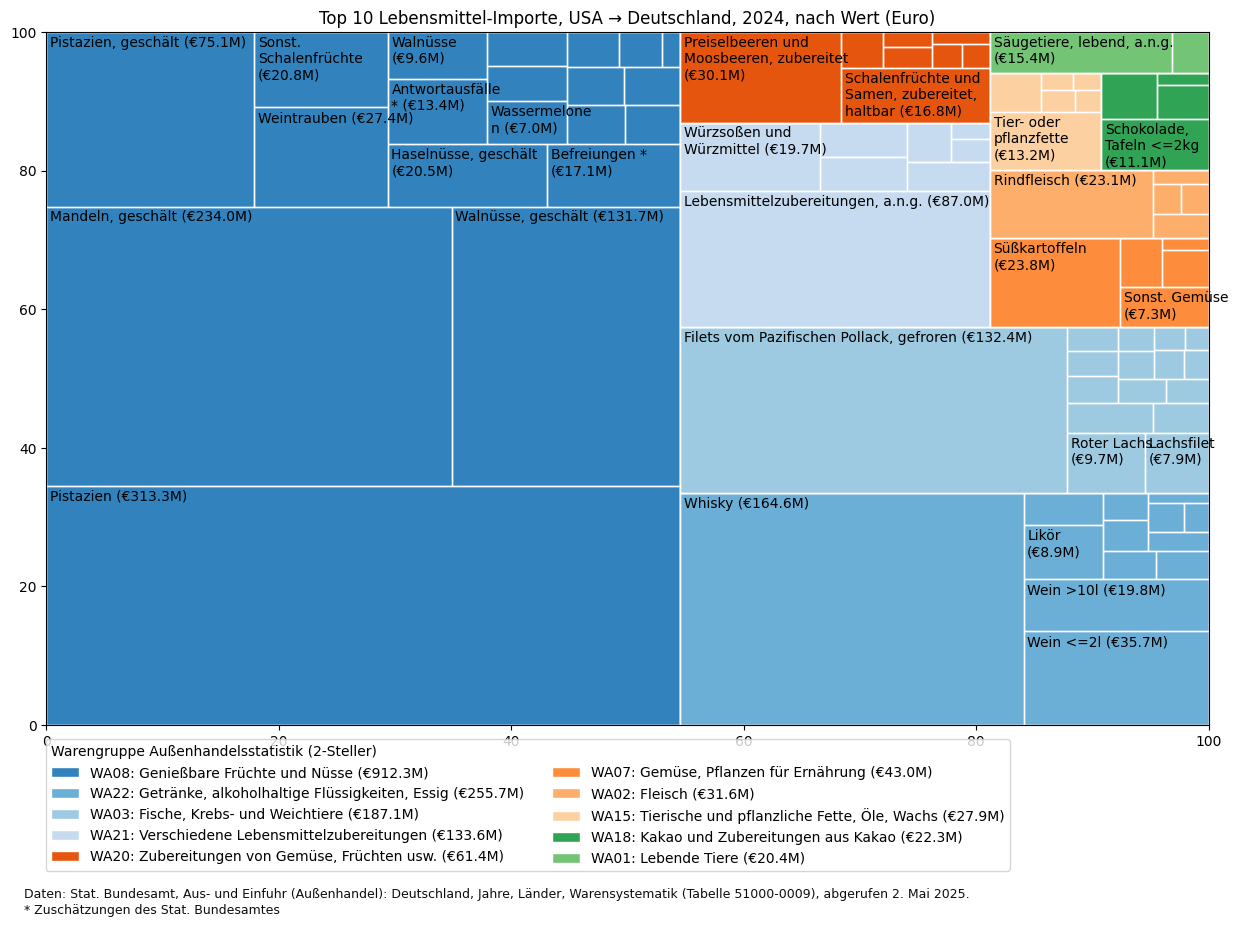

In [37]:
d = top_imports_2d.sort_values("value", ascending=False).reset_index()[:10][["product_code", "product_label", "value"]]
long_label = d["product_code"] + ": " + d["product_label"] + d["value"].map(lambda x: f" (€{round(x/1000, 1):,}M)")

short_labels = {
	"Weintrauben, frisch": "Weintrauben",
	"Wein aus frischen Weintrauben, >10l": "Wein >10l",
	"Wein aus frischen Weintrauben, <=2l": "Wein <=2l",
	"Schokolade, Tafeln u.a., ungef\u00fcllt, <=2kg": "Schokolade, Tafeln <=2kg",
	"Fleisch v. Rindern, ohne Knochen, frisch o.gek\u00fchlt": "Rindfleisch",
	"Mischungen von tierischen oder pflanzlichen Fetten": "Tier- oder pflanzfette",
	"Roter Lachs (Oncorhynchus nerka), gefroren": "Roter Lachs",
	"Filets vom Lachs, gefroren": "Lachsfilet",
	"Gem\u00fcse, a.n.g., getrocknet, geschnitten": "Sonst. Gemüse",
	"Waln\u00fcsse in der Schale, frisch oder getrocknet": "Walnüsse",
	"Wassermelonen, frisch": "Wassermelonen",
	"Pistazien in der Schale, frisch oder getrocknet": "Pistazien",
	"Pistazien ohne Schale, frisch oder getrocknet": "Pistazien, geschält",
	"Schalenfr\u00fcchte, a.n.g., frisch oder getrocknet": "Sonst. Schalenfrüchte",
	"Mandeln, frisch oder getrocknet, ohne Schale": "Mandeln, geschält",
	"Zusch\u00e4tzungen f\u00fcr Befreiungen (Kapitel 08)": "Befreiungen *",
	"Zusch\u00e4tzungen f\u00fcr Befreiungen (Kapitel 21)": "Befreiungen *",
	"Zusch\u00e4tzungen f\u00fcr Antwortausf\u00e4lle (Kapitel 08)": "Antwortausfälle *",
	"Zusch\u00e4tzungen f\u00fcr Antwortausf\u00e4lle (Kapitel 21)": "Antwortausfälle *",
	"Haseln\u00fcsse ohne Schale, frisch oder getrocknet": "Haselnüsse, geschält",
	"Waln\u00fcsse ohne Schale, frisch oder getrocknet": "Walnüsse, geschält",
	"S\u00fc\u00dfkartoffeln, frisch, gek\u00fchlt, gefroren": "Süßkartoffeln",
	"Zitronen und Limetten, frisch oder getrocknet": "Zitronen und Limetten",
	"Ausz\u00fcge, Essenzen und Konzentrate aus Tee, Mate": "Zub. Tee/Mate",
	"Pflaumen, getrocknet": "Getr. Pflaumen",
	"Roter Lachs (Oncorhynchus nerka), gefroren": "Roter Lachs",
}

nd = []
for di in d.to_dict("records"):
	sg = data["impex4d"].loc[
    	(data["impex4d"]["country"] == "Vereinigte Staaten von Amerika")
		& (data["impex4d"]["product_group_2d"] == di["product_code"])
		& ~(data["impex4d"]["Einfuhr: Wert"].isna())
		& ~(data["impex4d"]["Einfuhr: Wert"] < 1000)
	].rename(columns={"Einfuhr: Wert": "value"})
	sg["label"] = sg["product_label"].apply(lambda x: short_labels[x] if x in short_labels else x) + "\n" + sg["value"].apply(lambda x: f"(€{round(x/1000, 1):,}M)")
	if len(sg) > 0:
		nd.append(sg[["value", "product_code", "product_label", "label"]].to_dict("records"))

fig, ax = plt.subplots(figsize=(15,9))
plt.title("Top 10 Lebensmittel-Importe, USA → Deutschland, 2024, nach Wert (Euro)")
plot_nested_treemap(sort_tree([nd], "value"),fig=fig, ax=ax, key="value", label="label")
leg = fig.legend(long_label, loc="lower left", ncols=2, bbox_to_anchor=(.12, -0.06, .8, 1), title="Warengruppe Außenhandelsstatistik (2-Steller)")
leg._legend_box.align = "left"
ax.text(x=.11, y=-.1, s="Daten: Stat. Bundesamt, Aus- und Einfuhr (Außenhandel): Deutschland, Jahre, Länder, Warensystematik (Tabelle 51000-0009), abgerufen 2. Mai 2025.\n* Zuschätzungen des Stat. Bundesamtes", transform=fig.transFigure, ha='left', fontsize=9, alpha=.95, linespacing=1.35)
plt.show()

### Wie groß ist der Anteil von US-Importen an diesen Produktgruppen?

In [28]:
def compute_total_import_value(x, field):
	d = data["impex4d"].loc[
		(data["impex4d"]["product_code"] == x)
	]
	return d[field].sum()

result = pd.DataFrame()
for g2d in top_imports_2d["product_code"].values:
    res = data["impex4d"].loc[
        (data["impex4d"]["product_code"].str[:4] == g2d)
		& (data["impex4d"]["country"] == "Vereinigte Staaten von Amerika")
        & ~(data["impex4d"]["product_label"].str.contains("Zuschätzungen"))
	].nlargest(10, "Einfuhr: Wert")
    result = pd.concat([result, res])

result["total_import_value"] = result["product_code"].apply(lambda x: compute_total_import_value(x, "Einfuhr: Wert"))
result["total_import_weight"] = result["product_code"].apply(lambda x: compute_total_import_value(x, "Einfuhr: Gewicht"))

In [42]:
result["product_2d"] = result["product_code"].str[:4]
result["us_share_value"] = result["Einfuhr: Wert"].div(result["total_import_value"]).round(4)
result["us_share_weight"] = result["Einfuhr: Gewicht"].div(result["total_import_weight"]).round(4)

result_formatted = result[["product_label", "product_code", "total_import_value", "total_import_weight", "Einfuhr: Wert", "Einfuhr: Gewicht", "us_share_weight", "us_share_value"]].rename(columns={
    "product_code": "product_6d",
    "Einfuhr: Wert": "us_import_value",
    "Einfuhr: Gewicht": "us_import_weight"
})

result_formatted.to_csv("./output/imports.csv", index=False)
result_formatted

,product_label,product_6d,total_import_value,total_import_weight,us_import_value,us_import_weight,us_share_weight,us_share_value
858,"Pistazien in der Schale, frisch oder getrocknet",WA080251,331379.0,50350.5,313278.0,48012.0,0.9536,0.9454
859,"Mandeln, frisch oder getrocknet, ohne Schale",WA080212,449843.0,95575.3,234028.0,54447.2,0.5697,0.5202
858,"Walnüsse ohne Schale, frisch oder getrocknet",WA080232,215143.0,47107.4,131712.0,30701.3,0.6517,0.6122
859,"Pistazien ohne Schale, frisch oder getrocknet",WA080252,185052.0,13073.6,75089.0,5943.5,0.4546,0.4058
855,"Weintrauben, frisch",WA080610,992218.0,353134.8,27353.0,8922.3,0.0253,0.0276
...,...,...,...,...,...,...,...,...
856,"Papageienvögel, lebend",WA010632,481.0,0.1,235.0,0.0,0.0000,0.4886
855,"Insekten, andere",WA010649,8513.0,592.3,185.0,0.5,0.0008,0.0217
857,"Kaninchen und Hasen, lebend",WA010614,1008.0,10.8,126.0,2.3,0.2130,0.1250
858,"Enten, lebend, bis 185g",WA010513,6124.0,412.0,64.0,0.4,0.0010,0.0105
